In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv
import pandas as pd
c = 2.99792458 * 1e5 # units: km/s

In [13]:
plt.rcParams.update({'font.size': 25})


In [3]:
# read redshift and luminosity distance data from file
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
data = data_scp
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

redshift_scp = data_scp.T[1]
dist_mod_scp = data_scp.T[2] #pc
dist_mod_err_scp = data_scp.T[3] #pc
lum_dist_scp = 10**((dist_mod_scp - 25)/5)
lum_dist_err_scp = lum_dist_scp * np.log(10) * dist_mod_err_scp/5

In [4]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift_snls = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
color_error = data_snls.T[9]
dist_mod_snls = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err_snls = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)

lum_dist_snls = 10**((dist_mod_snls - 25)/5)
lum_dist_err_snls = lum_dist_snls * np.log(10) * dist_mod_err_snls/5

In [5]:
data_pan = np.genfromtxt('lcparam_full_long_zhel.txt')
redshift_pan = data_pan.T[1] #cmb
dist_mod_pan = data_pan.T[4]+19.5 #pc
dist_mod_err_pan = data_pan.T[5] #pc
lum_dist_pan = 10**((dist_mod_pan - 25)/5)
lum_dist_err_pan = lum_dist_pan * np.log(10) * dist_mod_err_pan/5

In [6]:
data_og = pd.read_csv('hubble_data.csv')
distance_og = data_og.iloc[:, 1]
velocity_og = data_og.iloc[:, 2]
redshift_og = velocity_og/3e5

In [7]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

In [8]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [9]:
bnds = ((0,0,60),(2,2,80))
poptscp, pcovscp = opt.curve_fit(D_L_helper, redshift_scp, lum_dist_scp, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_scp)
omega_m_scp, omega_lambda_scp, H_0_scp = poptscp
omega_m_err_scp, omega_lambda_err_scp, H_0_err_scp = np.sqrt(np.diag(pcovscp))

In [10]:
bnds = ((0,0,60),(2,2,80))
poptsnls, pcovsnls = opt.curve_fit(D_L_helper, redshift_snls, lum_dist_snls, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_snls)
omega_m_snls, omega_lambda_snls, H_0_snls = poptsnls
omega_m_err_snls, omega_lambda_err_snls, H_0_err_snls = np.sqrt(np.diag(pcovsnls))

In [11]:
bnds = ((0,0,60),(2,2,80))
poptpan, pcovpan = opt.curve_fit(D_L_helper, redshift_pan, lum_dist_pan, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_pan)
omega_m_pan, omega_lambda_pan, H_0_pan = poptpan
omega_m_err_pan, omega_lambda_err_pan, H_0_err_pan = np.sqrt(np.diag(pcovpan))

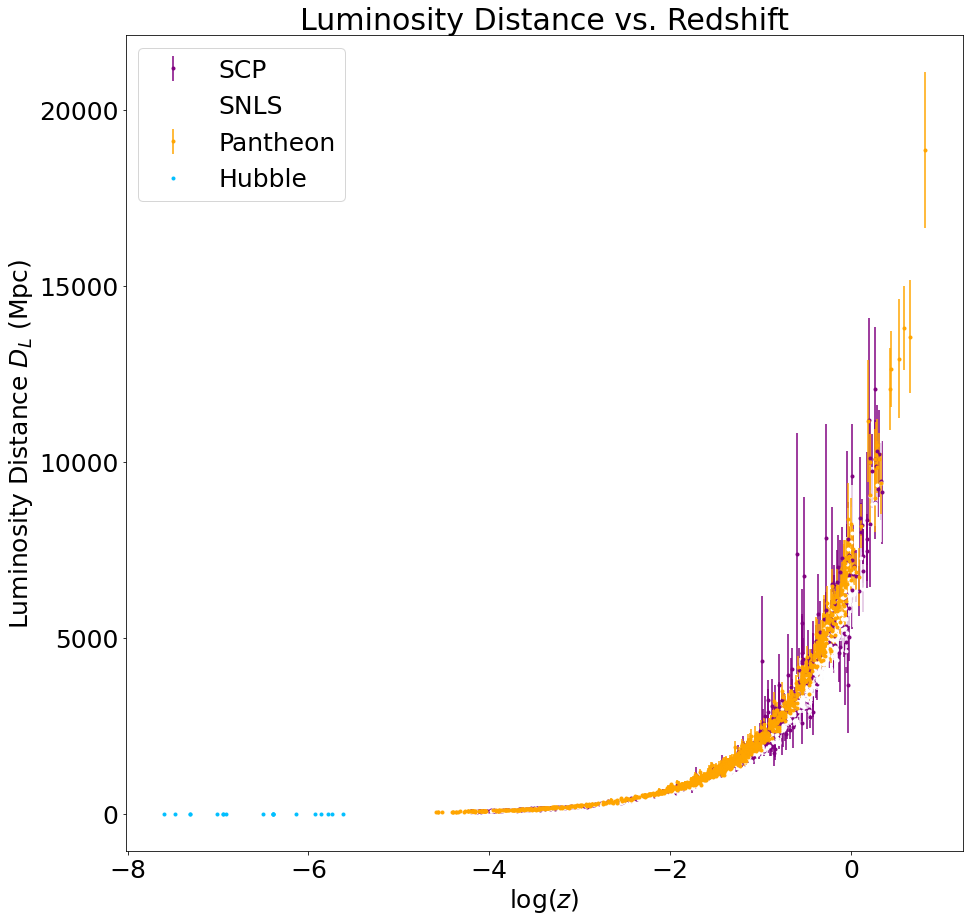

In [15]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift_scp),np.max(redshift_scp),1000)
plt.errorbar(np.log(redshift_scp),lum_dist_scp,yerr=lum_dist_err_scp,fmt='.',color='purple', label = 'SCP')
plt.errorbar(np.log(redshift_snls),lum_dist_snls,yerr=lum_dist_err_snls,fmt='.',color='white', label = 'SNLS')
plt.errorbar(np.log(redshift_pan),lum_dist_pan,yerr=lum_dist_err_pan,fmt='.',color='orange', label = 'Pantheon')
plt.errorbar(np.log(redshift_og),distance_og,fmt='.',color='deepskyblue', label = 'Hubble')


plt.xlabel("$\log(z)$")
plt.ylabel("Luminosity Distance $D_L$ (Mpc)")
plt.legend(loc='upper left')
plt.title("Luminosity Distance vs. Redshift")
plt.savefig('home_page_plot', dpi = 200)